<a href="https://colab.research.google.com/github/Dinesh29nov/RNN/blob/master/PoetryGenerationUsingLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <b/><font color = 'green' /> Poetry Generation using LSTM

#### <b/><font color='green'/> Libraries 

In [0]:
# Basic packages 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Deep learning packages specific to keras
from keras.models import Model
from keras.layers import Dense, Embedding, Input, LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam, SGD

Using TensorFlow backend.


In [0]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#### <b/><font color='green'/> Global Constants 

In [0]:
MAX_SEQUENENCE_LENGTH = 100
MAX_VOCAB_SIZE = 3000
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 2000
LATENT_DIM = 25

#### <b/><font color='green'/> Data Loading and Preprocessing 

In [0]:
input_text = []
target_text = []
for line in open('/content/drive/My Drive/DataNLP/robert_frost.txt'):
  line = line.rstrip()
  if not line:
    continue
  input_line = '<sos> ' + line
  output_line = line + ' <eos>'
  input_text.append(input_line)
  target_text.append(output_line)
  

In [0]:
all_lines = input_text + target_text

In [0]:
tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE, filters = '')
tokenizer.fit_on_texts(all_lines)
input_sequences = tokenizer.texts_to_sequences(input_text)
target_sequences = tokenizer.texts_to_sequences(target_text)

In [9]:
input_sequences[0]

[1, 104, 537, 538, 9, 7, 539, 540]

In [10]:
input_text[0]

'<sos> Two roads diverged in a yellow wood,'

In [11]:
max_sequence_length_from_data = max(len(s) for s in input_sequences)
max_sequence_length_from_data

12

In [0]:
word2idx = tokenizer.word_index
assert('<sos>' in word2idx)

assert('<eos>' in word2idx)

In [0]:
max_sequences_length = min(max_sequence_length_from_data, MAX_SEQUENENCE_LENGTH)
input_sequences = pad_sequences(input_sequences, maxlen=max_sequences_length, padding='post')
target_sequences = pad_sequences(target_sequences, maxlen=max_sequences_length, padding='post')

In [18]:
input_sequences[0]

array([  1, 104, 537, 538,   9,   7, 539, 540,   0,   0,   0,   0],
      dtype=int32)

####  <b/><font color ='green'/> Loading Pre-Trained word Vectors

In [19]:
if not os.path.exists('glove.6B.zip'):
  ! wget http://nlp.stanford.edu/data/glove.6B.zip

--2020-01-15 06:21:45--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-01-15 06:21:45--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-01-15 06:21:45--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [20]:
if not os.path.exists('glove.6B.50d.txt'):
  ! unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [0]:
word2vec = {}
with open('glove.6B.%sd.txt'%EMBEDDING_DIM) as f:
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.array(values[1:], dtype='float32')
    word2vec[word] = vec

In [0]:
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

In [0]:
one_hot_targets = np.zeros((len(input_sequences), max_sequences_length, num_words))
for i, target_sequence in enumerate(target_sequences):
  for t, word in enumerate(target_sequence):
    if word > 0:
      one_hot_targets[i, t, word] = 1

In [28]:
one_hot_targets.shape

(1436, 12, 3000)

In [29]:
# load pre-trained word embeddings into an Embedding layer
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  # trainable=False
)



In [31]:
input_ = Input(shape=(max_sequences_length,))
initial_h = Input(shape=(LATENT_DIM,))
initial_c = Input(shape=(LATENT_DIM,))
x = embedding_layer(input_)
lstm = LSTM(LATENT_DIM, return_sequences=True, return_state=True)
x, _, _ = lstm(x, initial_state=[initial_h, initial_c]) # don't need the states here
dense = Dense(num_words, activation='softmax')
output = dense(x)

model = Model([input_, initial_h, initial_c], output)
model.compile(
  loss='categorical_crossentropy',
  # optimizer='rmsprop',
  optimizer=Adam(lr=0.01),
  # optimizer=SGD(lr=0.01, momentum=0.9),
  metrics=['accuracy']
)

print('Training model...')
z = np.zeros((len(input_sequences), LATENT_DIM))
r = model.fit(
  [input_sequences, z, z],
  one_hot_targets,
  batch_size=BATCH_SIZE,
  epochs=5,
  validation_split=VALIDATION_SPLIT
)












Training model...
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1148 samples, validate on 288 samples
Epoch 1/5
1148/1148 [==============================] - 4s 3ms/step - loss: 5.3920 - acc: 0.0176 - val_loss: 5.0626 - val_acc: 0.0226
Epoch 2/5
1148/1148 [==============================] - 2s 2ms/step - loss: 4.6351 - acc: 0.0335 - val_loss: 4.8296 - val_acc: 0.0226
Epoch 3/5
1148/1148 [==============================] - 3s 2ms/step - loss: 4.3633 - acc: 0.0735 - val_loss: 4.8905 - val_acc: 0.0833
Epoch 4/5
1148/1148 [==============================] - 3s 2ms/step - loss: 4.3113 - acc: 0.0833 - val_loss: 4.9402 - val_acc: 0.0833
Epoch 5/5
1148/1148 [==============================] - 3s 2ms/step - loss: 4.2630 - acc: 0.0833 - val_loss: 4.9820 - val_acc: 0.0833


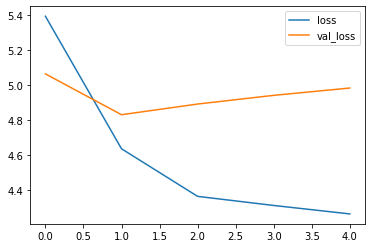

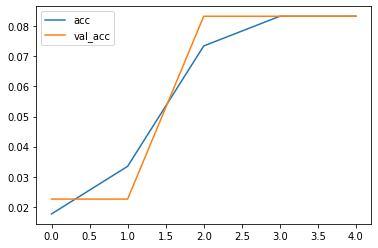

In [32]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

In [0]:
# make a sampling model
input2 = Input(shape=(1,)) # we'll only input one word at a time
x = embedding_layer(input2)
x, h, c = lstm(x, initial_state=[initial_h, initial_c]) # now we need states to feed back in
output2 = dense(x)
sampling_model = Model([input2, initial_h, initial_c], [output2, h, c])


# reverse word2idx dictionary to get back words
# during prediction
idx2word = {v:k for k, v in word2idx.items()}


In [0]:
def sample_line():
  # initial inputs
  np_input = np.array([[ word2idx['<sos>'] ]])
  h = np.zeros((1, LATENT_DIM))
  c = np.zeros((1, LATENT_DIM))

  # so we know when to quit
  eos = word2idx['<eos>']

  # store the output here
  output_sentence = []

  for _ in range(max_sequences_length):
    o, h, c = sampling_model.predict([np_input, h, c])

    # print("o.shape:", o.shape, o[0,0,:10])
    # idx = np.argmax(o[0,0])
    probs = o[0,0]
    if np.argmax(probs) == 0:
      print("wtf")
    probs[0] = 0
    probs /= probs.sum()
    idx = np.random.choice(len(probs), p=probs)
    if idx == eos:
      break

    # accuulate output
    output_sentence.append(idx2word.get(idx, '<WTF %s>' % idx))

    # make the next input into model
    np_input[0,0] = idx

  return ' '.join(output_sentence)

In [37]:
while True:
  for _ in range(4):
    print(sample_line())

  ans = input("---generate another? [Y/n]---")
  if ans and ans[0].lower().startswith('n'):
    break

live this his behind the you the born
brook she we at became of field. burned back and
recognize
drink descend her of headless his happened caught town herself.' these know.
---generate another? [Y/n]---y
as and he's but bear
me been the others' box,
always house, a and across me, a rouse build i inner a
town too, the a the drowned
---generate another? [Y/n]---n
